In [1]:
%matplotlib inline
import glob
import os
import pylab
import matplotlib.pyplot as plt
import numpy.ma as ma

import pcraster as pcr
import rasterio as rio

pylab.rcParams['figure.figsize'] = (15.0, 25.0)

In [2]:
pcr.setglobaloption("lddin")

In [2]:
for f in glob.glob('../temp/SRTM_90_max12_5040088850*'):
    os.remove(f)
!unzip ../work/SRTM_max12_2/done/SRTM_90_max12_5040088850.zip -d ../temp/
!gdal_translate -a_nodata -9999 -of PCRaster -ot Float32 ../temp/SRTM_90_max12_5040088850.elevation.tif ../temp/SRTM_90_max12_5040088850.elevation.map

Archive:  ../work/SRTM_max12_2/done/SRTM_90_max12_5040088850.zip
  inflating: ../temp/SRTM_90_max12_5040088850.elevation.tfw  
  inflating: ../temp/SRTM_90_max12_5040088850.elevation.tif  
Input file size is 2816, 2369
0...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
path = r'../temp/SRTM_90_max12_5040088850.elevation.map'

In [4]:
dem = pcr.readmap(path)
dem_np = pcr.pcr_as_numpy(dem)
print(dem_np.shape)

(2369, 2816)


In [5]:
xmin=0
xmax=dem_np.shape[0]
ymin=0
ymax=3000 # dem_np.shape[1]

/usr/local/lib/python2.7/dist-packages/numpy-1.12.0.dev0+12ec338-py2.7-linux-x86_64.egg/numpy/ma/core.py:3113: FutureWarning: Currently, slicing will try to return a view of the data, but will return a copy of the mask. In the future, it will try to return both as views.
  FutureWarning


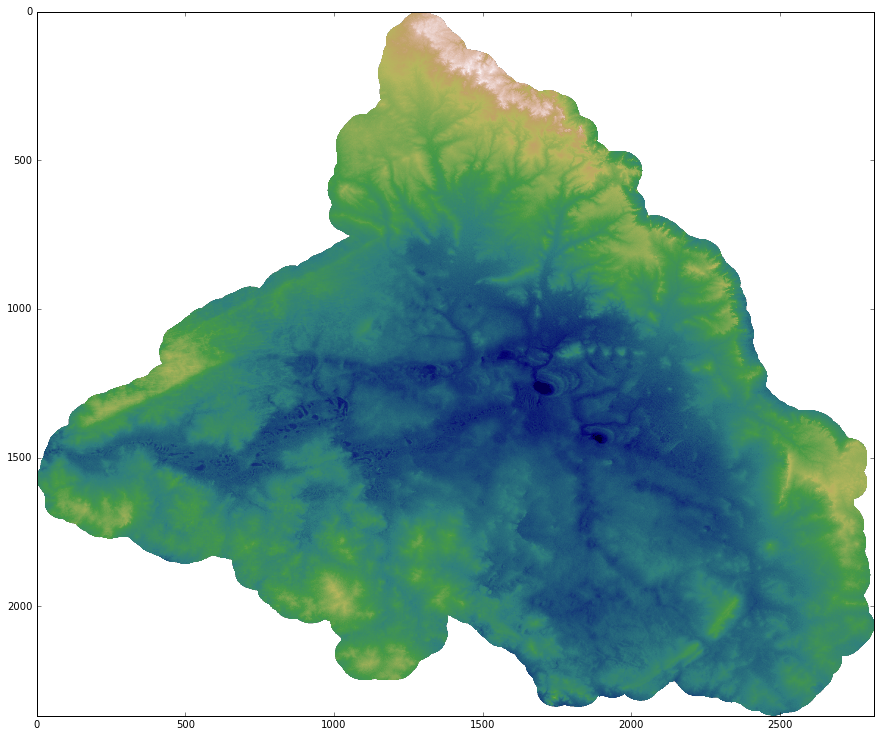

In [6]:
plt.imshow(dem_np[xmin:xmax, ymin:ymax], cmap=plt.cm.gist_earth)

In [ ]:
# NOTE: this does not work as expected!
# TODO: convert to meter!

# pixel_size = 0.000277778 # in degrees, equal to ~30m
# pcr.setglobaloption('unitcell')
# dem = pcr.cover(dem, -9999)
# slope = pcr.slope(dem  * pixel_size)
# pcr.report(slope, path[:-4] + '_slope.map')

In [7]:
path_slope =  path[:-4] + '_slope.tif'
scaling_factor = 1 / 0.000277778 
print(scaling_factor)

!gdaldem slope $path $path_slope -s $scaling_factor

3599.99712
0...10...20...30...40...50...60...70...80...90...100 - done.


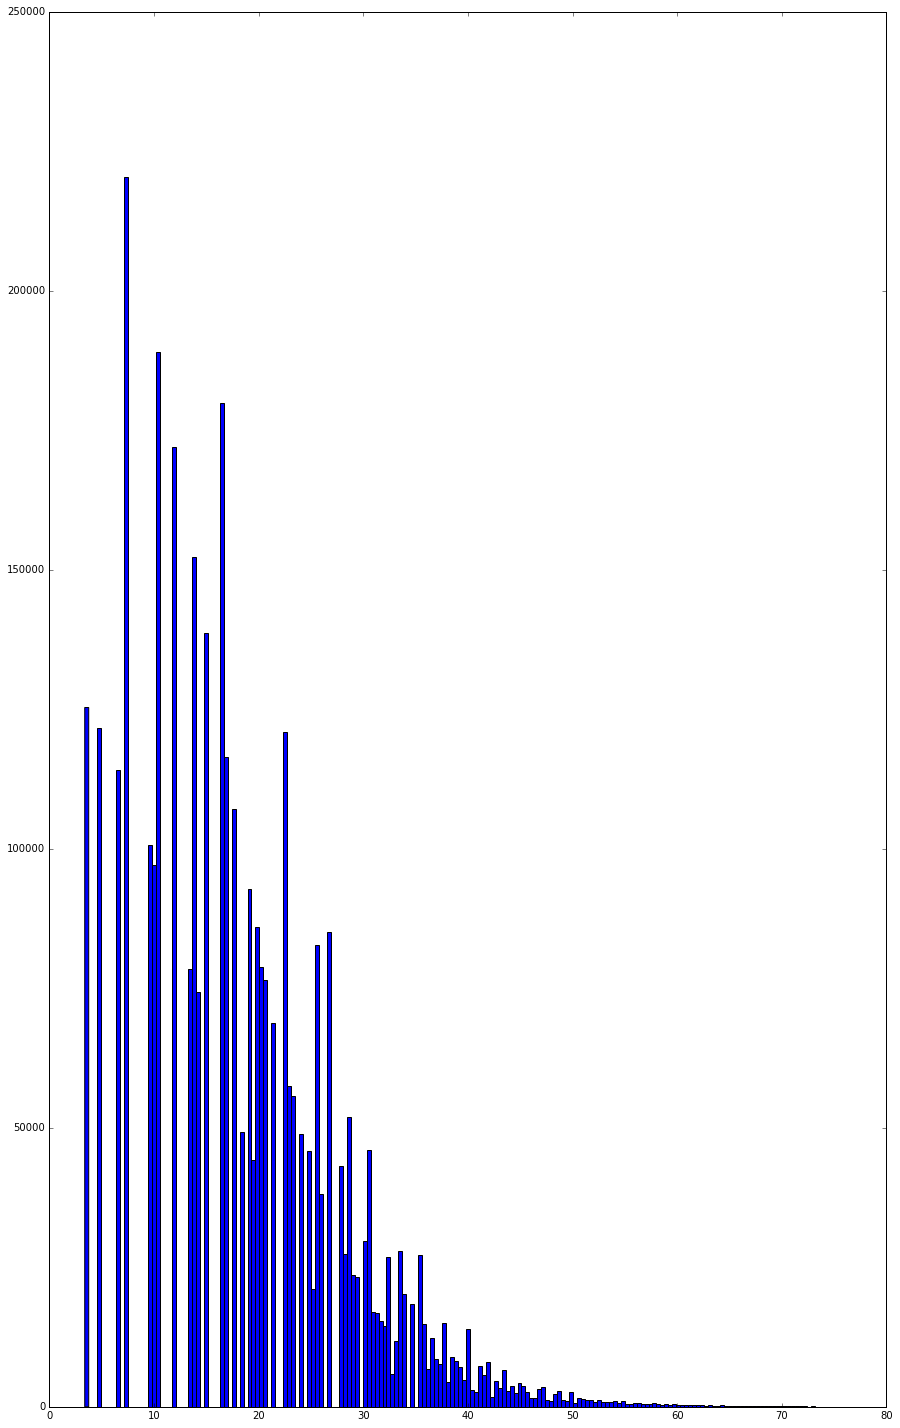

In [8]:
slope_np = rio.open(path_slope).read()[0]
_ = plt.hist(slope_np[slope_np > 0], bins=200)

In [9]:
slope_np = ma.masked_equal(slope_np, -9999)
slope_np = ma.masked_equal(slope_np, 0)

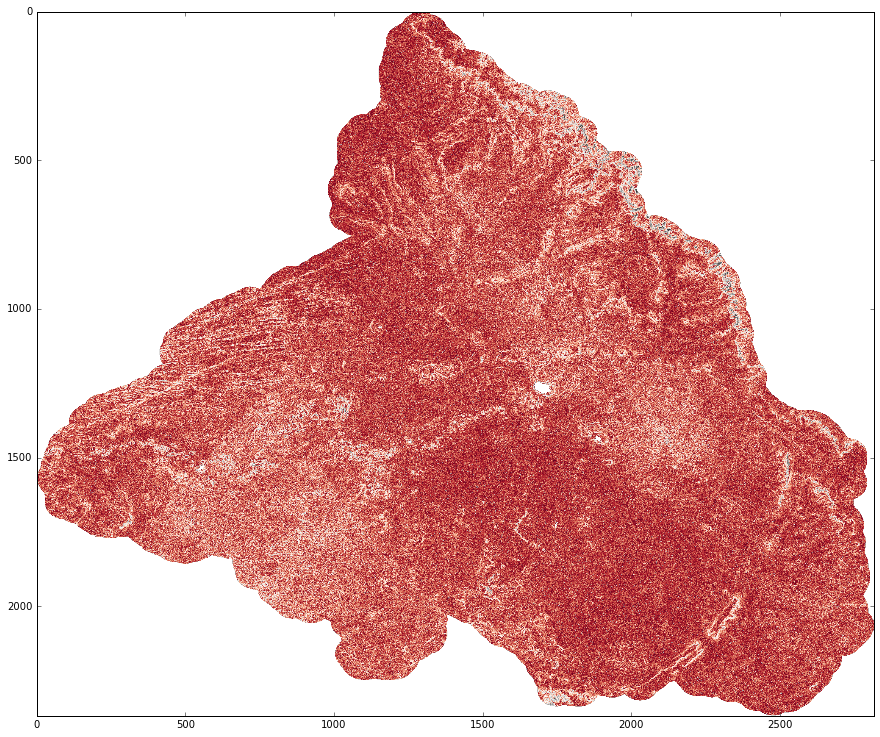

In [10]:
plt.imshow(slope_np[xmin:xmax, ymin:ymax], cmap='RdGy')

In [7]:
# enable pit filling
ldd = pcr.lddcreate(dem, 9999999, 9999999, 9999999, 9999999)
pcr.report(ldd, path[:-4] + '_ldd_in.map')

ldd_np = pcr.pcr_as_numpy(ldd)
ldd_np = ma.masked_equal(ldd_np, 255)

In [8]:
ldd = pcr.readmap(path[:-4] + '_ldd_in.map')

In [9]:
dem_pitfilled = pcr.lddcreatedem(dem, 9999999, 9999999, 9999999, 9999999)
# dem_pitfilled = pcr.cover(dem_pitfilled, -100.0)
pcr.report(dem_pitfilled, path[:-4] + '_pitfilled_dem_in.map')

In [10]:
dem_pitfilled = pcr.readmap(path[:-4] + '_pitfilled_dem_in.map')

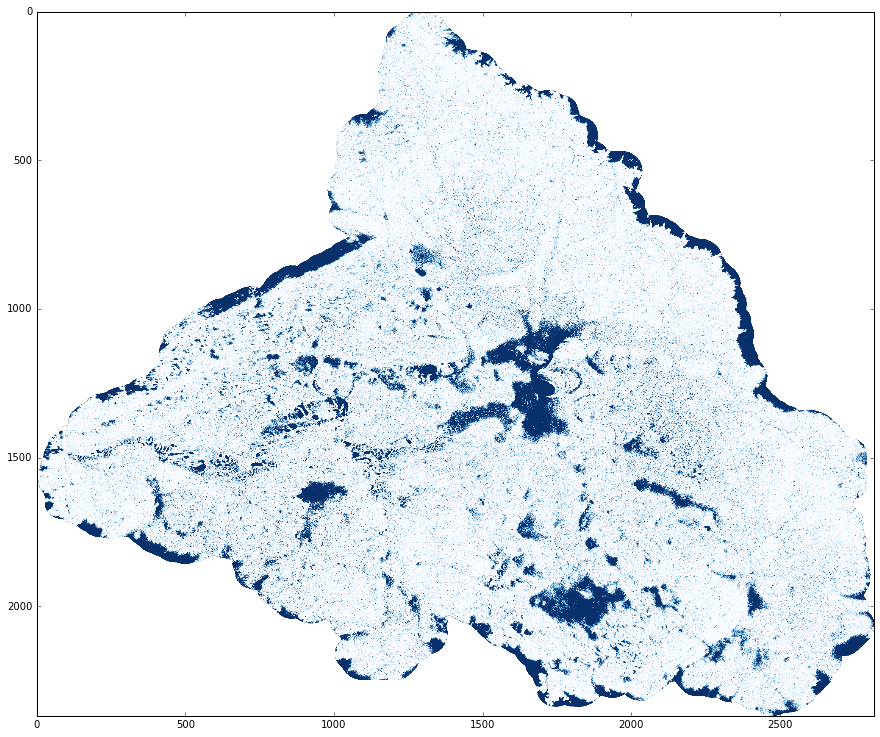

In [11]:
dem_diff = dem_pitfilled - dem
pcr.report(dem_diff, path[:-4] + '_pitfilled_dem_diff_in.map')

dem_diff_np = pcr.pcr_as_numpy(dem_diff)
plt.imshow(dem_diff_np[xmin:xmax, ymin:ymax], vmin=0, vmax=3, cmap='Blues')

In [12]:
# check nodata values
from osgeo import gdal
ds = gdal.Open(path[:-4] + '_pitfilled_dem_in.map')
band1 = ds.GetRasterBand(1)
print(band1.GetNoDataValue())

-3.40282346639e+38


[[-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 ..., 
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]
 [-100. -100. -100. ..., -100. -100. -100.]]


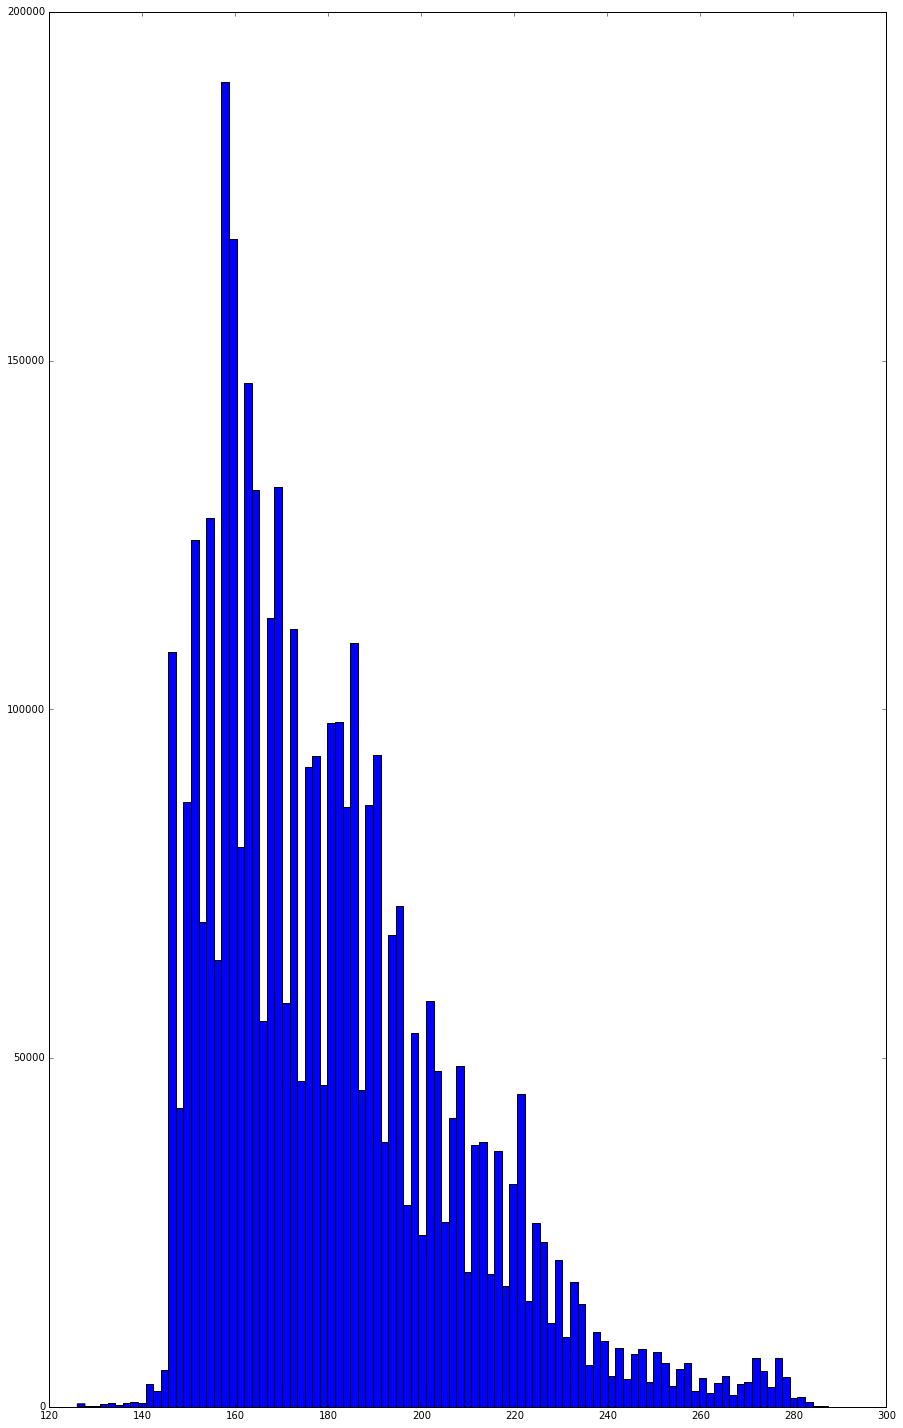

In [13]:
dem_pitfilled_np = pcr.pcr_as_numpy(dem_pitfilled)
from numpy import isnan
dem_pitfilled_np[isnan(dem_pitfilled_np)] = -100
print(dem_pitfilled_np)
_ = plt.hist(dem_pitfilled_np[dem_pitfilled_np > -100], bins=100)

1


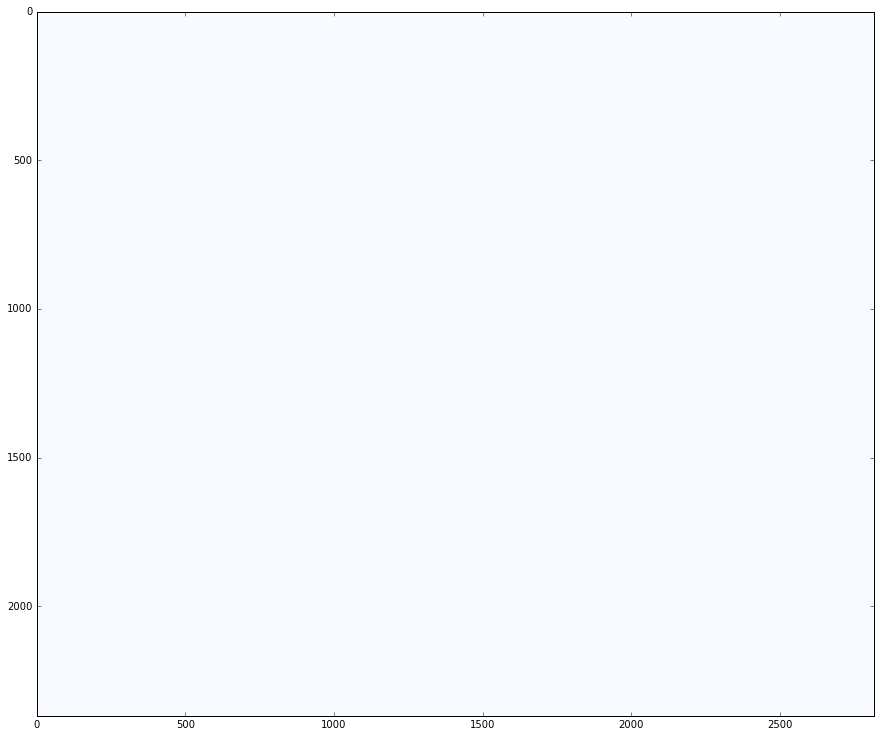

In [31]:
pits = pcr.pit(ldd)

pcr.report(pits, path[:-4] + '_pits_in.map')

pits_np=pcr.pcr_as_numpy(pits)
# pits_np=ma.masked_equal(pits_np, -2147483648)

print(len(pits_np[pits_np>0]))

# convert to binary image
# dilated = binary_dilation(pits_np, iterations=2, mask=(pits_np >= 0))
plt.imshow(pits_np[xmin:xmax, ymin:ymax], cmap='Blues', vmin=0, vmax=1)

In [15]:
catchments = pcr.catchment(ldd, pcr.pit(ldd))
pcr.report(catchments, path[:-4] + '_catchments_in.map')

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


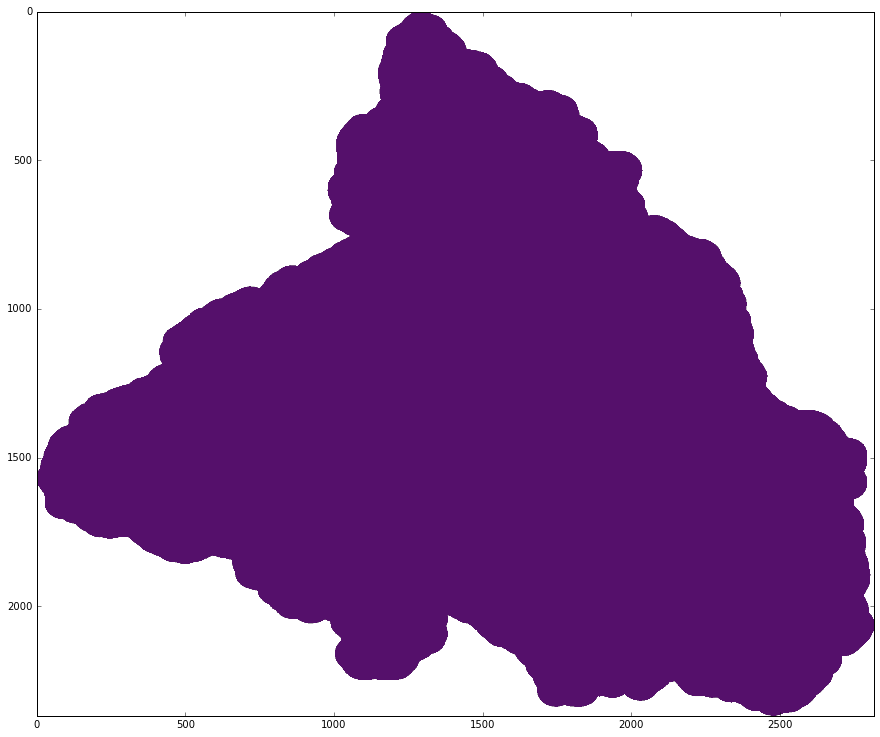

In [16]:
catchments_np = pcr.pcr_as_numpy(catchments)
catchments_np=ma.masked_equal(catchments_np, -2147483648)

print(catchments_np)
import matplotlib.colors
import numpy as np
cmap = matplotlib.colors.ListedColormap ( np.random.rand (len(catchments_np),3))
plt.imshow(catchments_np[xmin:xmax, ymin:ymax], cmap=cmap, vmin=0)

Create pits in the main river, see:

http://drm.cenn.org/Hazard_assessment_files/eng/Report_Flood%20Assessment%20in%20Georgia.pdf

In [ ]:
# ldd_pits = pcr.readmap(path[:-4] + '_ldd_with_pits.map')
# stream_order = pcr.readmap(path[:-4b] + '_streamorder.map')
# flowaccu = pcr.readmap(path[:-4] + '_flowaccu.map')

In [17]:
stream_order = pcr.streamorder(ldd)
stream_order_np = pcr.pcr_as_numpy(stream_order)
stream_order_np = ma.masked_equal(stream_order_np, -2147483648)
pcr.report(stream_order, path[:-4] + '_streamorder_in.map')

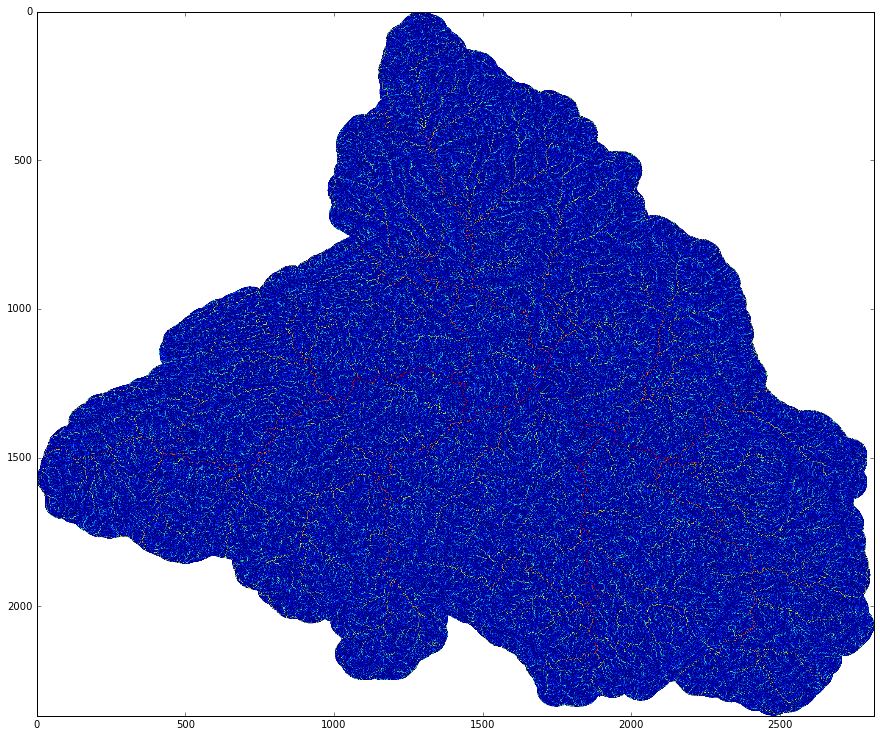

In [18]:
plt.imshow(stream_order_np[xmin:xmax, ymin:ymax])

In [19]:
flowaccu = pcr.accuflux(ldd, 1)
pcr.report(flowaccu, path[:-4] + '_flowaccu_in.map')

In [20]:
flowaccu = pcr.readmap(path[:-4] + '_flowaccu_in.map')

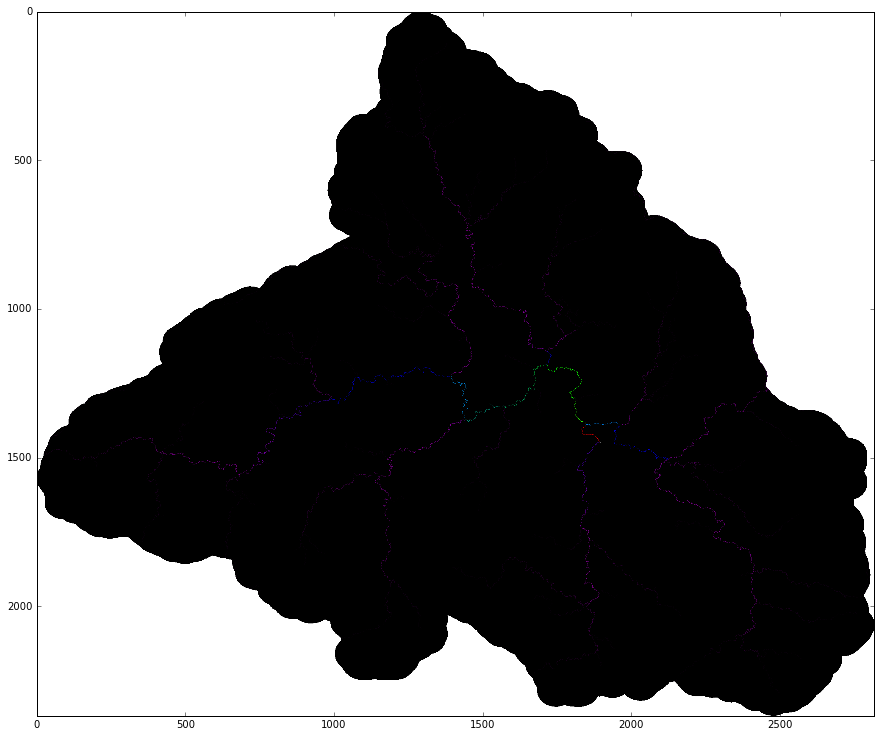

In [21]:
flowaccu_np = pcr.pcr_as_numpy(flowaccu)
plt.imshow(flowaccu_np[xmin:xmax, ymin:ymax], cmap='spectral')

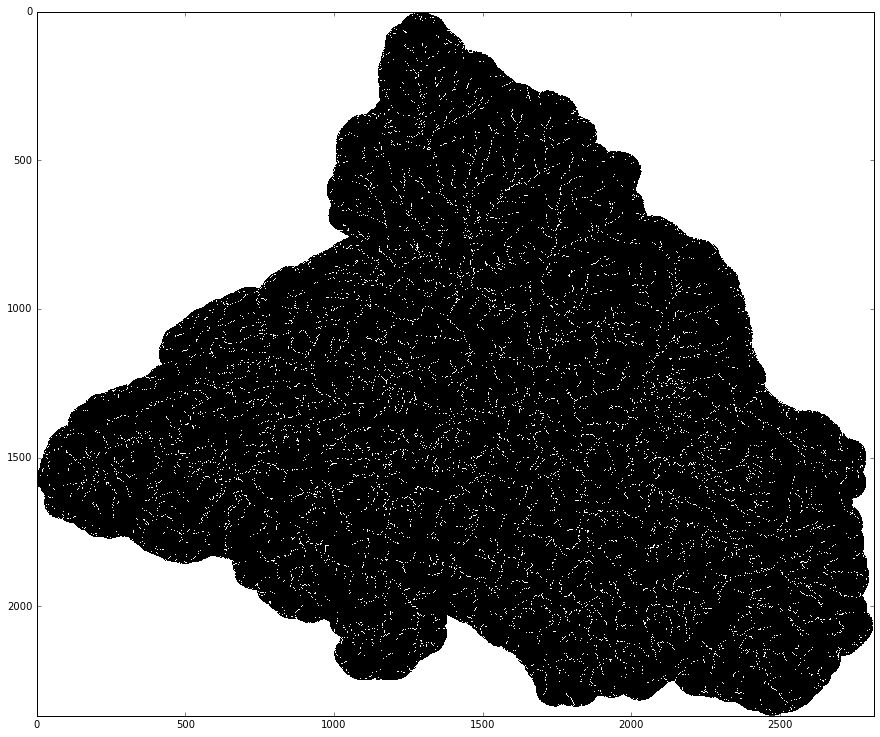

In [32]:
accuThreshold = 556
stream = pcr.ifthenelse(pcr.accuflux(ldd, 1) >= accuThreshold, pcr.boolean(1), pcr.boolean(0))

stream_np = pcr.pcr_as_numpy(stream)
stream_np = ma.masked_equal(stream_np, 255)

plt.imshow(stream_np[xmin:xmax, ymin:ymax], interpolation='none', cmap='gray')

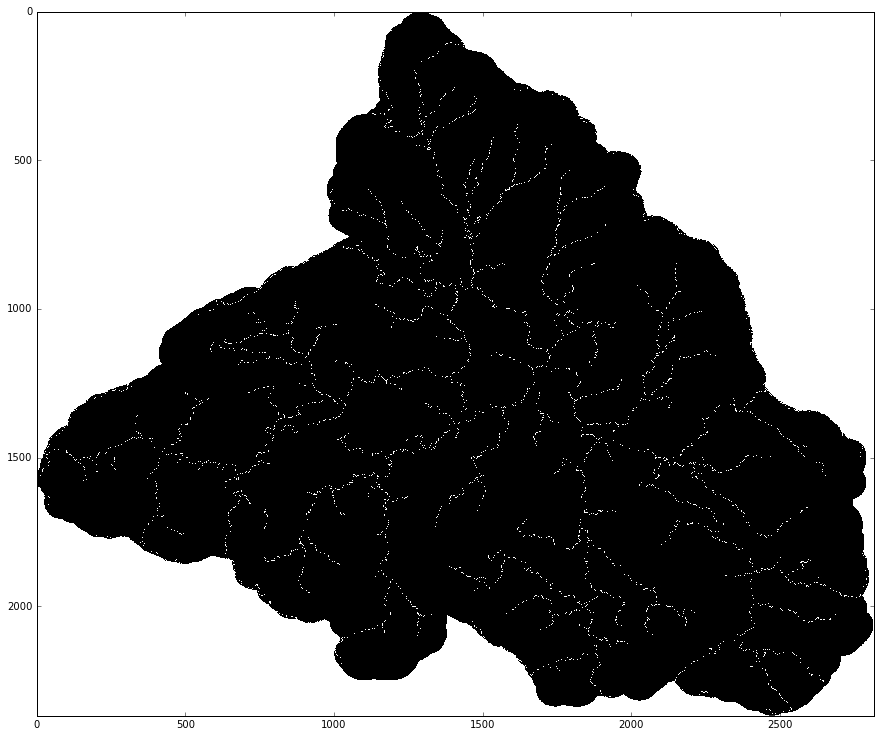

In [34]:
streamThr = 7
stream = pcr.ifthenelse(stream_order >= streamThr, pcr.boolean(1), pcr.boolean(0))

stream_np = pcr.pcr_as_numpy(stream)
stream_np = ma.masked_equal(stream_np, 255)

plt.imshow(stream_np, interpolation='none', cmap='gray')



In [35]:
height_river = pcr.ifthenelse(stream, pcr.ordinal(dem), 0)
up_elevation = pcr.scalar(pcr.subcatchment(ldd, height_river))

facc_river = pcr.ifthenelse(stream, pcr.ordinal(flowaccu), 0)
up_flowaccu = pcr.scalar(pcr.subcatchment(ldd, facc_river))

hand = pcr.max(dem-up_elevation, 0)
dist = pcr.ldddist(ldd, stream, 1)

In [36]:
pcr.report(up_flowaccu, path[:-4] + '_faccand_in.map')
pcr.report(hand, path[:-4] + '_hand_in.map')
pcr.report(dist, path[:-4] + '_dist_in.map')

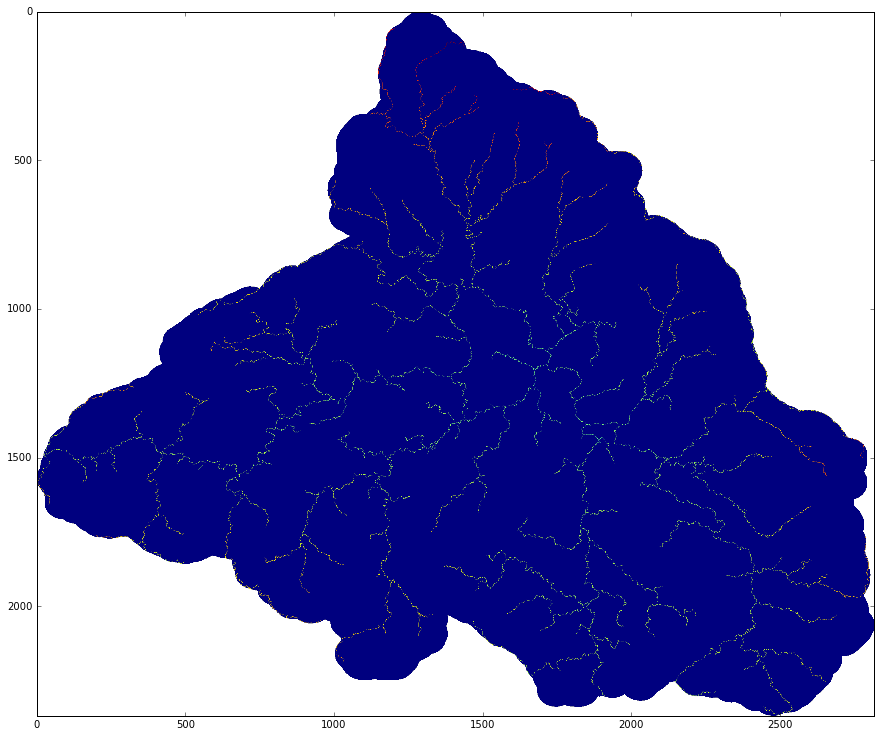

In [37]:
height_river_np = pcr.pcr_as_numpy(height_river)
height_river_np = ma.masked_equal(height_river_np, -2147483648)
plt.imshow(height_river_np)

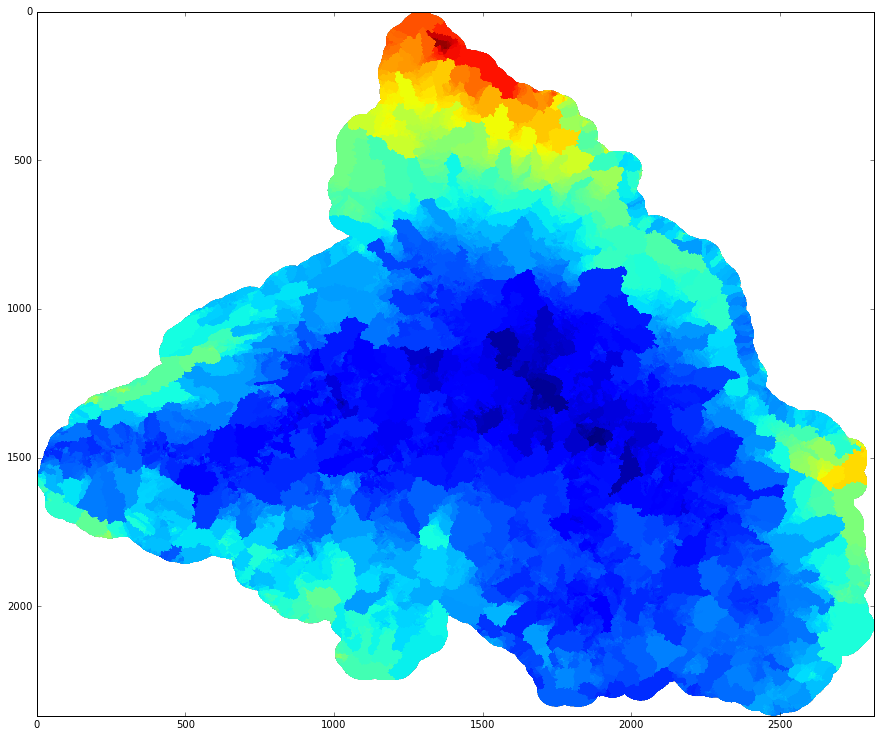

In [39]:
up_elevation_np = pcr.pcr_as_numpy(up_elevation)
plt.imshow(up_elevation_np)

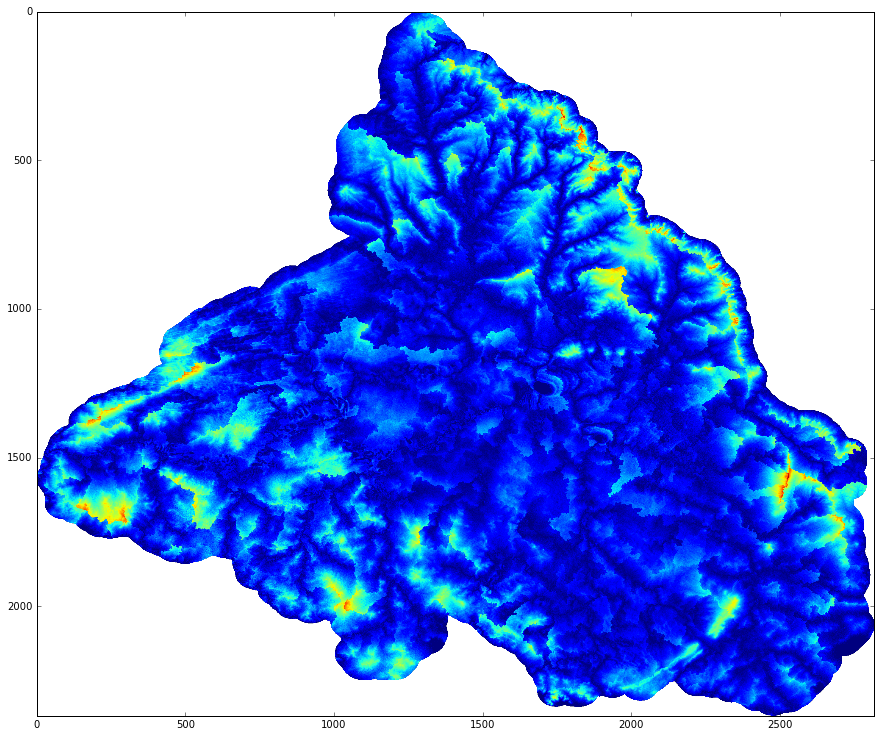

In [40]:
hand_np = pcr.pcr_as_numpy(hand)
plt.imshow(hand_np)

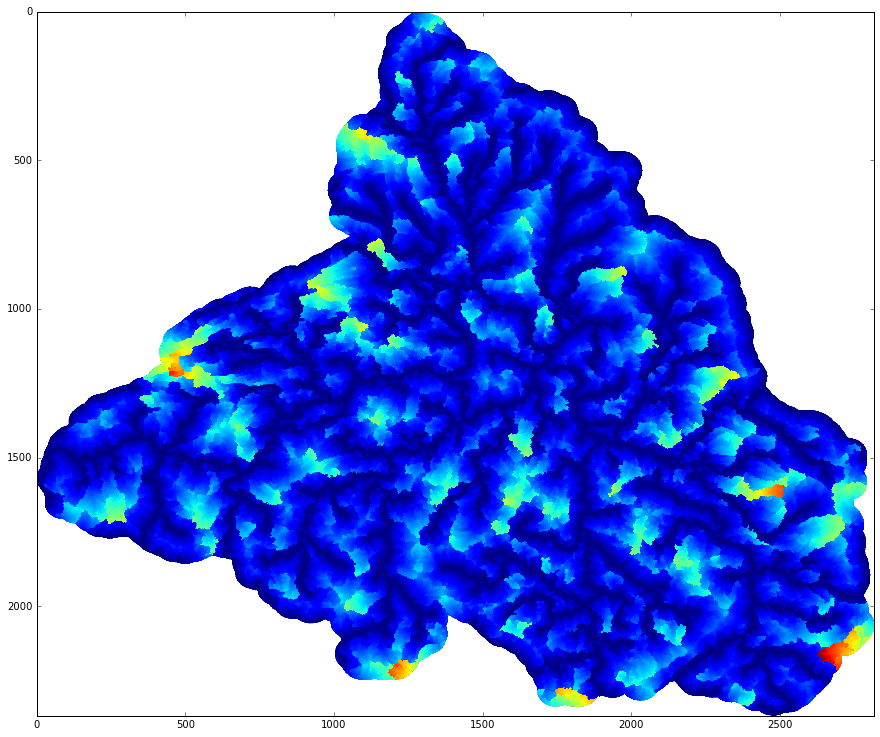

In [41]:
dist_np = pcr.pcr_as_numpy(dist)
plt.imshow(dist_np)

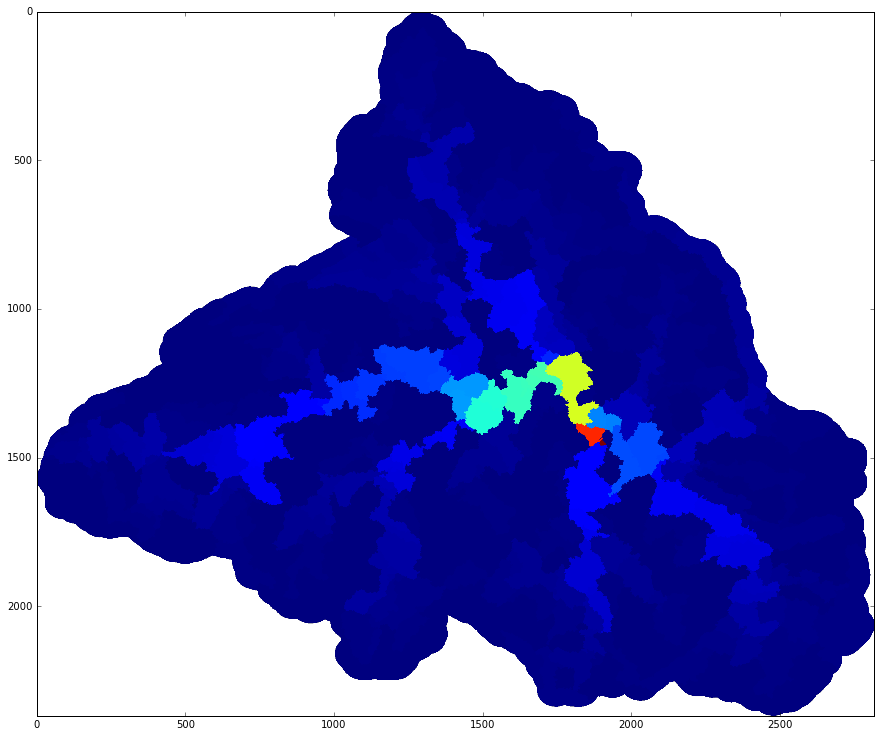

In [42]:
up_flowaccu_np = pcr.pcr_as_numpy(up_flowaccu)
plt.imshow(up_flowaccu_np)